# CycleGAN

**Author:** [A_K_Nain](https://twitter.com/A_K_Nain)<br>
**Date created:** 2020/08/12<br>
**Last modified:** 2020/08/12<br>
**Description:** Implementation of CycleGAN.

## CycleGAN

CycleGAN is a model that aims to solve the image-to-image translation
problem. The goal of the image-to-image translation problem is to learn the
mapping between an input image and an output image using a training set of
aligned image pairs. However, obtaining paired examples isn't always feasible.
CycleGAN tries to learn this mapping without requiring paired input-output images,
using cycle-consistent adversarial networks.

- [Paper](https://arxiv.org/pdf/1703.10593.pdf)
- [Original implementation](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix)

## Setup

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

#import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_addons as tfa
import tensorflow_datasets as tfds

tfds.disable_progress_bar()
autotune = tf.data.experimental.AUTOTUNE



## Prepare the dataset

In [3]:
import pandas as pd
import os
from glob import glob
data_rep = "/shared/ds/data/compvis/maize/fusarium/_DATASET_REVIEWED_348IMG/ZIPs/VIGNETS_WITHOUT_OVERLAPP/"
#data_descritp_filep = os.path.join(data_rep, "vignettes_classes.csv")
#data_df = pd.read_csv(data_descritp_filep)
fps =  glob(os.path.join(data_rep,"**/*.JPG"),recursive=True)
len(fps)
data_df=pd.DataFrame([{"file_name":os.path.basename(f),
                       "file_path":f,
                       "class":os.path.basename(f).split("__")[0] } for f in fps])

In [4]:
print(data_df.shape)
data_df.head()
data_df.groupby("class").agg(np.random.choice)

(73180, 3)


file_name  \
class                          
BK     BK__IMG_2173__333.JPG   
C       C__IMG_1485__145.JPG   
H       H__IMG_1346__112.JPG   

                                               file_path  
class                                                     
BK     /shared/ds/data/compvis/maize/fusarium/_DATASE...  
C      /shared/ds/data/compvis/maize/fusarium/_DATASE...  
H      /shared/ds/data/compvis/maize/fusarium/_DATASE...

In [5]:
# NOTE : groupby+sample works only with pandas >=1.1.0
DF = data_df.groupby("class").sample(n=1400, random_state=42)

In [6]:
DF = DF[~(DF["class"]=="BK")]

In [7]:
DF.head()

file_name  \
66499   C__IMG_0197__46.JPG   
39639  C__IMG_1870__244.JPG   
13621   C__IMG_1509__84.JPG   
67707   C__IMG_1341__71.JPG   
12391   C__IMG_2183__95.JPG   

                                               file_path class  
66499  /shared/ds/data/compvis/maize/fusarium/_DATASE...     C  
39639  /shared/ds/data/compvis/maize/fusarium/_DATASE...     C  
13621  /shared/ds/data/compvis/maize/fusarium/_DATASE...     C  
67707  /shared/ds/data/compvis/maize/fusarium/_DATASE...     C  
12391  /shared/ds/data/compvis/maize/fusarium/_DATASE...     C

In [8]:
DF.tail()
np.random.randint(0,)

ValueError: low >= high

In [9]:
from sklearn.model_selection import train_test_split
train_H_df, test_val_H_df = train_test_split(DF[DF["class"]=="H"],train_size = 0.7145)
test_H_df, val_H_df = train_test_split(test_val_H_df,train_size = 0.5)

train_C_df, test_val_C_df = train_test_split(DF[DF["class"]=="C"],train_size = 0.7145)
test_C_df, val_C_df = train_test_split(test_val_C_df,train_size = 0.5)

In [77]:
print(train_H_df.shape)
print(test_H_df.shape)
print(val_H_df.shape)
print(train_C_df.shape)
print(test_C_df.shape)
print(val_C_df.shape)

(1000, 4)
(200, 5)
(200, 4)
(1000, 4)
(200, 4)
(200, 4)


In [71]:
train_H_df = train_H_df.assign(key = list(np.arange(0,train_H_df.shape[0],1)))
train_C_df = train_C_df.assign(key = list(np.arange(0,train_C_df.shape[0],1)))
test_H_df = test_H_df.assign(key = list(np.arange(0,test_H_df.shape[0],1)))
test_C_df = test_C_df.assign(key = list(np.arange(0,test_C_df.shape[0],1)))
val_H_df = val_H_df.assign(key = list(np.arange(0,val_H_df.shape[0],1)))
val_C_df = val_C_df.assign(key = list(np.arange(0,val_C_df.shape[0],1)))

In [80]:
train_df = pd.merge(train_H_df, train_C_df, how="inner", left_on=["key"], right_on=["key"])
test_df = pd.merge(test_H_df, test_C_df, how="inner", left_on=["key"], right_on=["key"])
val_df = pd.merge(val_H_df, val_C_df, how="inner", left_on=["key"], right_on=["key"])

In [81]:
train_df.head()

file_name_x                                        file_path_x  \
0  H__IMG_1756__155.JPG  /shared/ds/data/compvis/maize/fusarium/_DATASE...   
1  H__IMG_1466__207.JPG  /shared/ds/data/compvis/maize/fusarium/_DATASE...   
2  H__IMG_1307__144.JPG  /shared/ds/data/compvis/maize/fusarium/_DATASE...   
3  H__IMG_1054__266.JPG  /shared/ds/data/compvis/maize/fusarium/_DATASE...   
4  H__IMG_1496__177.JPG  /shared/ds/data/compvis/maize/fusarium/_DATASE...   

  class_x  key           file_name_y  \
0       H    0  C__IMG_2173__271.JPG   
1       H    1  C__IMG_2173__174.JPG   
2       H    2   C__IMG_0095__15.JPG   
3       H    3  C__IMG_1747__235.JPG   
4       H    4  C__IMG_2170__135.JPG   

                                         file_path_y class_y  
0  /shared/ds/data/compvis/maize/fusarium/_DATASE...       C  
1  /shared/ds/data/compvis/maize/fusarium/_DATASE...       C  
2  /shared/ds/data/compvis/maize/fusarium/_DATASE...       C  
3  /shared/ds/data/compvis/maize/fusarium/_DATASE...       C  
4  /shared/ds/data/compvis/maize/fusarium/_DATASE...       C

In [13]:
# validation_set=tf.data.Dataset.from_tensor_slices(
#    x_val.reshape(x_val.shape[0], 784).astype("float32")/255
# )
# validation_set=validation_set.map(lambda x:(x,x))
# validation_set=validation_set.batch(32)
# vae.evaluate(validation_set)

In [14]:
# Define the standard image size.
orig_img_size = (286, 286)
# Size of the random crops to be used during training.
input_img_size = (256, 256, 3)

def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    # Map values in the range [-1, 1]
    return (img / 127.5) - 1.0

def preprocess_train_image(img, label=None):
    # Random flip
    img = tf.image.random_flip_left_right(img)
    # Resize to the original size first
    img = tf.image.resize(img, [*input_img_size[0:2]])
    #####img = tf.image.resize(img, [*orig_img_size])
    # Random crop to 256X256
    ##### img = tf.image.random_crop(img, size=[*input_img_size])
    # Normalize the pixel values in the range [-1, 1]
    img = normalize_img(img)
    return img

def preprocess_test_image(img, label=None):
    # Only resizing and normalization for the test images.
    img = tf.image.resize(img, [input_img_size[0], input_img_size[1]])
    img = normalize_img(img)
    return img

In [195]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
class ImageDataGeneratorCouples(ImageDataGenerator):

    def get_indices_from_keras_generator(gen, batch_size):
        """
        Given a keras data generator, it returns the indices and the filepaths
        corresponding the current batch.
        :param gen: keras generator.
        :param batch_size: size of the last batch generated.
        :return: tuple with indices and filenames
        """

        idx_left = (gen.batch_index - 1) * batch_size
        idx_right = idx_left + gen.batch_size if idx_left >= 0 else None
        indices = gen.index_array[idx_left:idx_right]
        filenames = [gen.filenames[i] for i in indices]
        return indices, filenames

    def flow_2pics_from_dataframe(self, dataframe, x_col2, *args, **kwargs):
        generator = super().flow_from_dataframe(dataframe, *args, **kwargs)

        while True:
             next(generator)

    # def flow_from_dataframe(self, dataframe, *args, **kwargs):
    #
    #     generator = super().flow_from_dataframe(dataframe, *args, **kwargs)
    #
    #     seed = None if 'seed' not in kwargs else kwargs['seed']
    #     #print(generator.filepaths)
    #     #print(f"seed {seed}")
    #     while True:
    #         for image_path in generator.filepaths:
    #             # Get augmented image samples
    #             image = next(generator)
    #             #print(image_path)
    #
    #             yield image, image_path

file_name  \
12036  H__IMG_1756__155.JPG   
43370  H__IMG_1466__207.JPG   
5315   H__IMG_1307__144.JPG   
60036  H__IMG_1054__266.JPG   

                                               file_path class  key  
12036  /shared/ds/data/compvis/maize/fusarium/_DATASE...     H    0  
43370  /shared/ds/data/compvis/maize/fusarium/_DATASE...     H    1  
5315   /shared/ds/data/compvis/maize/fusarium/_DATASE...     H    2  
60036  /shared/ds/data/compvis/maize/fusarium/_DATASE...     H    3

In [260]:
train_H_df.iloc[0:5,:]

file_name  \
12036  H__IMG_1756__155.JPG   
43370  H__IMG_1466__207.JPG   
5315   H__IMG_1307__144.JPG   
60036  H__IMG_1054__266.JPG   
69426  H__IMG_1496__177.JPG   

                                               file_path class  key  
12036  /shared/ds/data/compvis/maize/fusarium/_DATASE...     H    0  
43370  /shared/ds/data/compvis/maize/fusarium/_DATASE...     H    1  
5315   /shared/ds/data/compvis/maize/fusarium/_DATASE...     H    2  
60036  /shared/ds/data/compvis/maize/fusarium/_DATASE...     H    3  
69426  /shared/ds/data/compvis/maize/fusarium/_DATASE...     H    4

In [393]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
batch_size = 1

def get_indices_from_keras_generator(gen, batch_size):
    """
    Given a keras data generator, it returns the indices and the filepaths
    corresponding the current batch.
    :param gen: keras generator.
    :param batch_size: size of the last batch generated.
    :return: tuple with indices and filenames
    """

    idx_left = (gen.batch_index - 1) * batch_size
    idx_right = idx_left + gen.batch_size if idx_left >= 0 else None
    indices = gen.index_array[idx_left:idx_right]
    filenames = [gen.filenames[i] for i in indices]
    return indices, filenames

class ImageDataGeneratorWithPath(ImageDataGenerator):
    def flow_from_dataframe(self, dataframe, *args, **kwargs):
        generator = super().flow_from_dataframe(dataframe, *args, **kwargs)
        seed = None if 'seed' not in kwargs else kwargs['seed']
        #print(f"{(generator.batch_index - 1)* batch_size} : {generator.filepaths}")

        #print(f"seed {seed}")
        print(len([os.path.basename(f) for f in (generator.filepaths)]))
        #while True:
        imgs= []
            #img_paths = []
        for image_path in generator.filepaths:
            # Get augmented image samples
            #print(f"___{generator.batch_index}")
            img = next(generator)
            #imgs.append()
            #print(f"___{generator.batch_index}")
            idx_left = (generator.batch_index - 1) * batch_size
            print(f"__{idx_left}:{os.path.basename(image_path)}")
            yield img, image_path

        #yield tf.concat(imgs, axis=0), generator.filepaths
#ImageDataGeneratorWithPath
train_data_generator = ImageDataGenerator(preprocessing_function=preprocess_train_image #,dtype='float32'
                                          )

test_data_generator = ImageDataGenerator(preprocessing_function=preprocess_test_image #,dtype='float32'
                                          )


train_H = train_data_generator.flow_from_dataframe(dataframe=train_H_df.iloc[0:200,:],directory= None,
                                                   target_size=input_img_size[0:2],
                                                   x_col='file_path',
                                                   y_col='class',
                                                   batch_size=batch_size,
                                                   class_mode=None,
                                                   shuffle=False
                                                  )
train_C = train_data_generator.flow_from_dataframe(dataframe=train_C_df.iloc[0:200,:],directory= None,
                                                   target_size=input_img_size[0:2],
                                                   x_col='file_path',
                                                   y_col='class',
                                                   batch_size=batch_size,
                                                   class_mode=None,
                                                   shuffle=False
                                                  )

test_H = test_data_generator.flow_from_dataframe(dataframe=test_H_df, directory=None,
                                                 target_size=input_img_size[0:2],
                                                 x_col='file_path',
                                                 y_col='class',
                                                 class_mode=None,
                                                 batch_size=batch_size
                                                 )

test_C = test_data_generator.flow_from_dataframe(dataframe=test_C_df, directory=None,
                                                 target_size=input_img_size[0:2],
                                                 x_col='file_path',
                                                 y_col='class',
                                                 class_mode=None,
                                                 batch_size=batch_size
                                                 )

Found 200 validated image filenames.
Found 200 validated image filenames.
Found 200 validated image filenames.
Found 200 validated image filenames.


In [331]:
test_C.n

200

In [394]:
# def generate_with_file_name(datagen):
#     while True:
#         batch = next(datagen)
#         current_index = ((datagen.batch_index-1) * datagen.batch_size)
#         if current_index < 0:
#             if datagen.samples % datagen.batch_size > 0:
#                 current_index = max(0,datagen.samples - datagen.samples % datagen.batch_size)
#             else:
#                 current_index = max(0,datagen.samples - datagen.batch_size)
#         index_array = datagen.index_array[current_index:current_index + datagen.batch_size].tolist()
#         img_paths = [datagen.filepaths[idx] for idx in index_array]

def cycle_gan_datagen_np_OLD(data_gen1, data_gen2):

    imgs1, imgs2 = [], []
    #while True:
    for i in range(data_gen2.batch_size):
        x_1 = next(data_gen1)
        x_2 = next(data_gen2)
        print(f"shapes x_1, x_2 : {x_1.shape}, {x_2.shape}")
        #for i in range(x_1.shape[0]):
            #print(f"_{i}:{os.path.basename(x_1_fp)} ({tf.reduce_sum(x_1)}) <> {os.path.basename(x_2_fp)} ({tf.reduce_sum(x_2)})")
        print(f"_{i}: ({tf.reduce_sum(x_1)}) <> ({tf.reduce_sum(x_2)})")
        imgs1.append(x_1)
        imgs2.append(x_2)
        #yield tf.expand_dims(x_1[0], axis=0), tf.expand_dims(x_2[0], axis=0)
    X1, X2=  tf.concat(imgs1, axis=0), tf.concat(imgs2, axis=0)
    print(f"shapes X1, X2 : {X1.shape}, {X2.shape}")
    yield X1, X2

def cycle_gan_datagen_np(data_gen1, data_gen2):
    #i, max = 0, 20
    while True:
        # if i>max:
        #     print("BREAKKKKKKKKK")
        #     break
        #i += 1
        x_1 = next(data_gen1)
        x_2 = next(data_gen2)
        #print(f"shapes x_1, x_2 : {x_1.shape}, {x_2.shape}")
        yield tf.convert_to_tensor(x_1), tf.convert_to_tensor(x_2)

def cycle_gan_datagen(data_gen1, data_gen2):
    while True:
        x_1, x_1_fp = next(data_gen1)
        x_2, x_2_fp = next(data_gen2)
        print(x_1_fp)
        for i in range(x_1.shape[0]):
            print(f"_{i}:{os.path.basename(x_1_fp[i])} ({tf.reduce_sum(x_1[i])}) <> {os.path.basename(x_2_fp[i])} ({tf.reduce_sum(x_2[i])})")
            yield tf.expand_dims(x_1[i], axis=0), tf.expand_dims(x_2[i], axis=0)
        #yield x_1, x_2

0
shapes x_1, x_2 : (1, 256, 256, 3), (1, 256, 256, 3)
(1, 256, 256, 3)
1
shapes x_1, x_2 : (1, 256, 256, 3), (1, 256, 256, 3)
(1, 256, 256, 3)
2
shapes x_1, x_2 : (1, 256, 256, 3), (1, 256, 256, 3)
(1, 256, 256, 3)
3
shapes x_1, x_2 : (1, 256, 256, 3), (1, 256, 256, 3)
(1, 256, 256, 3)
4
shapes x_1, x_2 : (1, 256, 256, 3), (1, 256, 256, 3)
(1, 256, 256, 3)
5
shapes x_1, x_2 : (1, 256, 256, 3), (1, 256, 256, 3)
(1, 256, 256, 3)
6
shapes x_1, x_2 : (1, 256, 256, 3), (1, 256, 256, 3)
(1, 256, 256, 3)
7
shapes x_1, x_2 : (1, 256, 256, 3), (1, 256, 256, 3)
(1, 256, 256, 3)


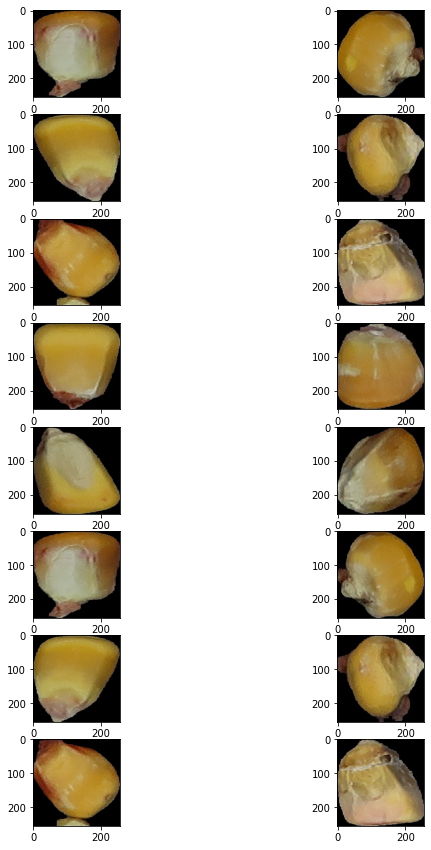

In [352]:
tot = 8
_, ax = plt.subplots(tot, 2, figsize=(10, 15))
#for i, [tkH, tkC] in enumerate(get_flow_from_generators(train_H, train_C)):
for i in range(tot):
    print(i)
    #if i > 3 :
    #    break
    tkH, tkC = next(cycle_gan_datagen_np(train_H, train_C))
    print(tkH.shape)
    #samples = zip(train_H.next(), train_C.next())
    #kH = (((samples[0][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    #kC = (((samples[1][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    #[tkH, tkC] = get_flow_from_generators(train_H, train_C)
    #AAA = get_flow_from_generators(train_H, train_C).next()
    #print(AAA)
    kH = (((tkH[0].numpy() * 127.5) + 127.5)).astype(np.uint8)
    kC = (((tkC[0].numpy() * 127.5) + 127.5)).astype(np.uint8)

    ax[i, 0].imshow(kH)
    ax[i, 1].imshow(kC)
plt.show()

0
_0: (-69537.3828125) <> (-44592.7421875)
(1, 256, 256, 3)
1
_0: (-61963.2890625) <> (-52249.45703125)
(1, 256, 256, 3)
2
_0: (-69537.3828125) <> (-44592.7421875)
(1, 256, 256, 3)
3
_0: (-61963.2890625) <> (-52249.45703125)
(1, 256, 256, 3)
4
_0: (-69537.3828125) <> (-44592.7421875)
(1, 256, 256, 3)
5
_0: (-61963.2890625) <> (-44592.7421875)
(1, 256, 256, 3)
6
_0: (-69537.3828125) <> (-52249.45703125)
(1, 256, 256, 3)
7
_0: (-61963.2890625) <> (-44592.7421875)
(1, 256, 256, 3)
8
_0: (-69537.3828125) <> (-52249.45703125)
(1, 256, 256, 3)
9
_0: (-61963.2890625) <> (-52249.45703125)
(1, 256, 256, 3)


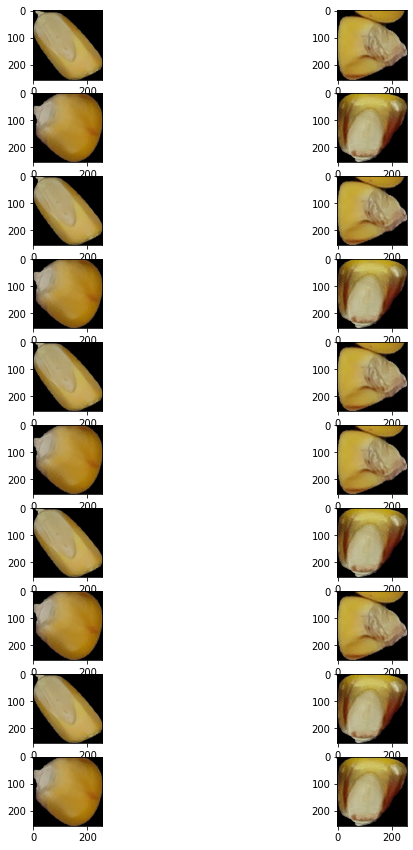

In [223]:
tot = 10
_, ax = plt.subplots(tot, 2, figsize=(10, 15))
#for i, [tkH, tkC] in enumerate(get_flow_from_generators(train_H, train_C)):
for i in range(tot):
    print(i)
    tkH, tkC = next(cycle_gan_datagen_np(test_H, test_C))
    print(tkH.shape)
    kH = (((tkH[0].numpy() * 127.5) + 127.5)).astype(np.uint8)
    kC = (((tkC[0].numpy() * 127.5) + 127.5)).astype(np.uint8)

    ax[i, 0].imshow(kH)
    ax[i, 1].imshow(kC)
plt.show()

In [ ]:
# def tf_data_gen(k_iterator):
#     yield k_iterator.next()

In [ ]:
# test_C_dataset = tf.data.Dataset.from_generator(tf_data_gen, (tf.float32), args=[test_H])

In [143]:
# # Assume batch size is 1
# def generator(sequence_type):
#     #print(f"{sequence_type}")
#     #yield()
#     if sequence_type == 1:
#         for i in range(5):
#             yield 10 + i
#     elif sequence_type == 2:
#         for i in range(5):
#             yield (30 + 3 * i, 60 + 2 * i)
#     elif sequence_type == 3:
#         for i in range(1, 4):
#             yield (i, ['Hi'] * i)
#
# dataset1 = tf.data.Dataset.from_generator(generator, (tf.int32), args = ([1]))
# # Emits data of 10, 11, 12, 13, 14, (One element at a time)
#
# dataset2 = tf.data.Dataset.from_generator(generator, (tf.int32, tf.int32), args = ([2]))
# # Emits data of (30, 60), (33, 62), (36, 64), (39, 66), (42, 68)
# # Emits one tuple at a time
#
# dataset3 = tf.data.Dataset.from_generator(generator, (tf.int32, tf.string), args = ([3]))
# # Emits data of (1, ['Hi']), (2, ['Hi', 'Hi']), (3, ['Hi', 'Hi', 'Hi'])
# # Emits one tuple at a time

(<tf.Tensor: shape=(), dtype=int32, numpy=30>, <tf.Tensor: shape=(), dtype=int32, numpy=60>)
(<tf.Tensor: shape=(), dtype=int32, numpy=33>, <tf.Tensor: shape=(), dtype=int32, numpy=62>)
(<tf.Tensor: shape=(), dtype=int32, numpy=36>, <tf.Tensor: shape=(), dtype=int32, numpy=64>)
(<tf.Tensor: shape=(), dtype=int32, numpy=39>, <tf.Tensor: shape=(), dtype=int32, numpy=66>)


In [156]:
# Load the horse-zebra dataset using tensorflow-datasets.
# dataset, _ = tfds.load("cycle_gan/horse2zebra", with_info=True, as_supervised=True)
# train_horses, train_zebras = dataset["trainA"], dataset["trainB"]
# test_horses, test_zebras = dataset["testA"], dataset["testB"]


# Weights initializer for the layers.
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

buffer_size = 256



## Create `Dataset` objects

In [78]:

# Apply the preprocessing operations to the training data
# train_horses = (
#     train_horses.map(preprocess_train_image, num_parallel_calls=autotune)
#     .cache()
#     .shuffle(buffer_size)
#     .batch(batch_size)
# )
# train_zebras = (
#     train_zebras.map(preprocess_train_image, num_parallel_calls=autotune)
#     .cache()
#     .shuffle(buffer_size)
#     .batch(batch_size)
# )
#
# # Apply the preprocessing operations to the test data
# test_horses = (
#     test_horses.map(preprocess_test_image, num_parallel_calls=autotune)
#     .cache()
#     .shuffle(buffer_size)
#     .batch(batch_size)
# )
# test_zebras = (
#     test_zebras.map(preprocess_test_image, num_parallel_calls=autotune)
#     .cache()
#     .shuffle(buffer_size)
#     .batch(batch_size)
# )


## Visualize some samples

In [79]:
dir(train_H)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__next__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_params',
 '_filepaths',
 '_filter_classes',
 '_filter_valid_filepaths',
 '_flow_index',
 '_get_batches_of_transformed_samples',
 '_keras_api_names',
 '_keras_api_names_v1',
 '_sample_weight',
 '_set_index_array',
 'allowed_class_modes',
 'batch_index',
 'batch_size',
 'class_mode',
 'color_mode',
 'data_format',
 'directory',
 'dtype',
 'filenames',
 'filepaths',
 'get_classes',
 'image_data_generator',
 'image_shape',
 'index_array',
 'index_generator',
 'interpolation',
 'labels',
 'lock',
 'n',
 'next',
 'on_epoch_end',
 'reset',
 'sample_weight',
 'samples'

In [98]:
for i in range(4):
    xxx = train_H.next()
    print(xxx.shape)
#for i in tf.data.Dataset.from_generator(train_H).take(3):
#    print(i)

(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)


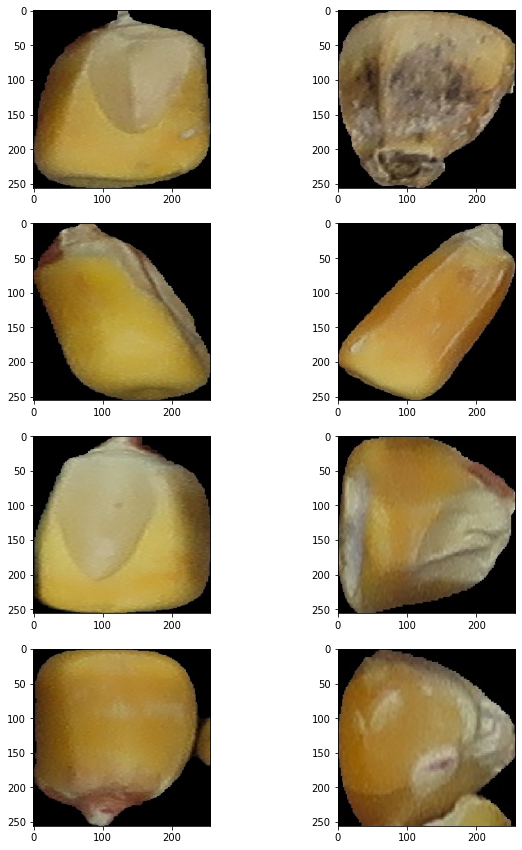

In [109]:

_, ax = plt.subplots(4, 2, figsize=(10, 15))
#for i, samples in enumerate(zip(train_H.take(4), train_C.take(4))):
for i in range(4):
    #samples = zip(train_H.next(), train_C.next())
    #kH = (((samples[0][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    #kC = (((samples[1][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    kH = (((train_H.next()[0] * 127.5) + 127.5)).astype(np.uint8)
    kC = (((train_C.next()[0] * 127.5) + 127.5)).astype(np.uint8)

    ax[i, 0].imshow(kH)
    ax[i, 1].imshow(kC)
plt.show()



## Building blocks used in the CycleGAN generators and discriminators

In [157]:

class ReflectionPadding2D(layers.Layer):
    """Implements Reflection Padding as a layer.

    Args:
        padding(tuple): Amount of padding for the
        spatial dimensions.

    Returns:
        A padded tensor with the same type as the input tensor.
    """

    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")


def residual_block(
    x,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="valid",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(input_tensor)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = activation(x)

    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.add([input_tensor, x])
    return x


def downsample(
    x,
    filters,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


def upsample(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2DTranspose(
        filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


## Build the generators

The generator consists of downsampling blocks: nine residual blocks
and upsampling blocks. The structure of the generator is the following:

```
c7s1-64 ==> Conv block with `relu` activation, filter size of 7
d128 ====|
         |-> 2 downsampling blocks
d256 ====|
R256 ====|
R256     |
R256     |
R256     |
R256     |-> 9 residual blocks
R256     |
R256     |
R256     |
R256 ====|
u128 ====|
         |-> 2 upsampling blocks
u64  ====|
c7s1-3 => Last conv block with `tanh` activation, filter size of 7.
```

In [158]:

def get_resnet_generator(
    filters=64,
    num_downsampling_blocks=2,
    num_residual_blocks=9,
    num_upsample_blocks=2,
    gamma_initializer=gamma_init,
    name=None,
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = ReflectionPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_init, use_bias=False)(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.Activation("relu")(x)

    # Downsampling
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation("relu"))

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=layers.Activation("relu"))

    # Upsampling
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.Activation("relu"))

    # Final block
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(3, (7, 7), padding="valid")(x)
    x = layers.Activation("tanh")(x)

    model = keras.models.Model(img_input, x, name=name)
    return model


## Build the discriminators

The discriminators implement the following architecture:
`C64->C128->C256->C512`

In [159]:

def get_discriminator(
    filters=64, kernel_initializer=kernel_init, num_downsampling=3, name=None
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = layers.Conv2D(
        filters,
        (4, 4),
        strides=(2, 2),
        padding="same",
        kernel_initializer=kernel_initializer,
    )(img_input)
    x = layers.LeakyReLU(0.2)(x)

    num_filters = filters
    for num_downsample_block in range(3):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(2, 2),
            )
        else:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(1, 1),
            )

    x = layers.Conv2D(
        1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer
    )(x)

    model = keras.models.Model(inputs=img_input, outputs=x, name=name)
    return model


# Get the generators
gen_G = get_resnet_generator(name="generator_G")
gen_F = get_resnet_generator(name="generator_F")

# Get the discriminators
disc_X = get_discriminator(name="discriminator_X")
disc_Y = get_discriminator(name="discriminator_Y")


## Build the CycleGAN model

We will override the `train_step()` method of the `Model` class
for training via `fit()`.

In [253]:

class CycleGan(keras.Model):
    def __init__(
        self,
        generator_G,
        generator_F,
        discriminator_X,
        discriminator_Y,
        lambda_cycle=10.0,
        lambda_identity=0.5,
    ):
        super(CycleGan, self).__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def compile(
        self,
        gen_G_optimizer,
        gen_F_optimizer,
        disc_X_optimizer,
        disc_Y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super(CycleGan, self).compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()

    def train_step(self, batch_data):
        # x is Horse and y is zebra
        real_x, real_y = batch_data

        # For CycleGAN, we need to calculate different
        # kinds of losses for the generators and discriminators.
        # We will perform the following steps here:
        #
        # 1. Pass real images through the generators and get the generated images
        # 2. Pass the generated images back to the generators to check if we
        #    we can predict the original image from the generated image.
        # 3. Do an identity mapping of the real images using the generators.
        # 4. Pass the generated images in 1) to the corresponding discriminators.
        # 5. Calculate the generators total loss (adversarial + cycle + identity)
        # 6. Calculate the discriminators loss
        # 7. Update the weights of the generators
        # 8. Update the weights of the discriminators
        # 9. Return the losses in a dictionary

        with tf.GradientTape(persistent=True) as tape:
            # Horse to fake zebra
            fake_y = self.gen_G(real_x, training=True)
            # Zebra to fake horse -> y2x
            fake_x = self.gen_F(real_y, training=True)

            # Cycle (Horse to fake zebra to fake horse): x -> y -> x
            cycled_x = self.gen_F(fake_y, training=True)
            # Cycle (Zebra to fake horse to fake zebra) y -> x -> y
            cycled_y = self.gen_G(fake_x, training=True)

            # Identity mapping
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            # Discriminator output
            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x, training=True)

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Generator adversarial loss
            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)

            # Generator cycle loss
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Generator identity loss
            id_loss_G = (
                self.identity_loss_fn(real_y, same_y)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_F = (
                self.identity_loss_fn(real_x, same_x)
                * self.lambda_cycle
                * self.lambda_identity
            )

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            # Discriminator loss
            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Get the gradients for the generators
        grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        # Get the gradients for the discriminators
        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        # Update the weights of the generators
        self.gen_G_optimizer.apply_gradients(
            zip(grads_G, self.gen_G.trainable_variables)
        )
        self.gen_F_optimizer.apply_gradients(
            zip(grads_F, self.gen_F.trainable_variables)
        )

        # Update the weights of the discriminators
        self.disc_X_optimizer.apply_gradients(
            zip(disc_X_grads, self.disc_X.trainable_variables)
        )
        self.disc_Y_optimizer.apply_gradients(
            zip(disc_Y_grads, self.disc_Y.trainable_variables)
        )

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
        }


## Create a callback that periodically saves generated images

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, num_img=2):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        _, ax = plt.subplots(self.num_img, 2, figsize=(6, 6))
        ###for i, img in enumerate(test_horses.take(self.num_img)):
        for i in range(self.num_img):
            imgs=test_H.next()
            #prediction = self.model.gen_G(imgs)[0]
            prediction = self.model.gen_G(tf.convert_to_tensor(imgs))[0].numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            #img = (imgs[0] * 127.5 + 127.5).numpy().astype(np.uint8)
            img = (imgs[0] * 127.5 + 127.5).astype(np.uint8)

            ax[i, 0].imshow(img)
            ax[i, 1].imshow(prediction)
            ax[i, 0].set_title("Input image")
            ax[i, 1].set_title("Translated image")
            ax[i, 0].axis("off")
            ax[i, 1].axis("off")

            prediction = keras.preprocessing.image.array_to_img(prediction)
            prediction.save(
                "generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch + 1)
            )
        plt.show()
        plt.close()


## Train the end-to-end model

In [401]:
# Loss function for evaluating adversarial loss
adv_loss_fn = keras.losses.MeanSquaredError()

# Define the loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss


# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5


# Create cycle gan model
cycle_gan_model = CycleGan(
    generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
)

# Compile the model
cycle_gan_model.compile(
    gen_G_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_F_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_X_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_Y_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
)
# Callbacks
plotter = GANMonitor()
chekpoint_fp = "./model_checkpoints/cyclegan_checkpoints"
checkpoint_filepath = chekpoint_fp+".{epoch:03d}"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath
)

Epoch 1/10
200/200 [==============================] - 201s 768ms/step - G_loss: 1.9281 - F_loss: 1.6731 - D_X_loss: 0.2497 - D_Y_loss: 0.2256

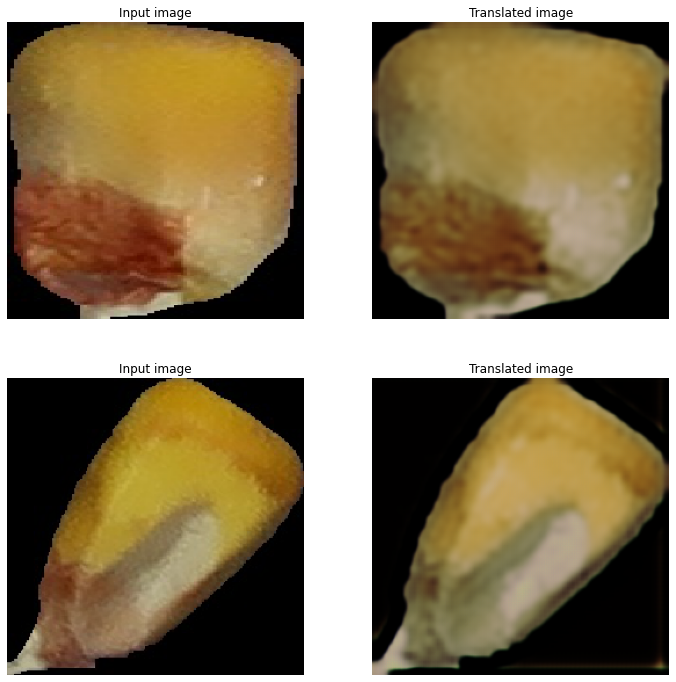

Epoch 2/10
200/200 [==============================] - 151s 753ms/step - G_loss: 1.8360 - F_loss: 1.5573 - D_X_loss: 0.2504 - D_Y_loss: 0.2234

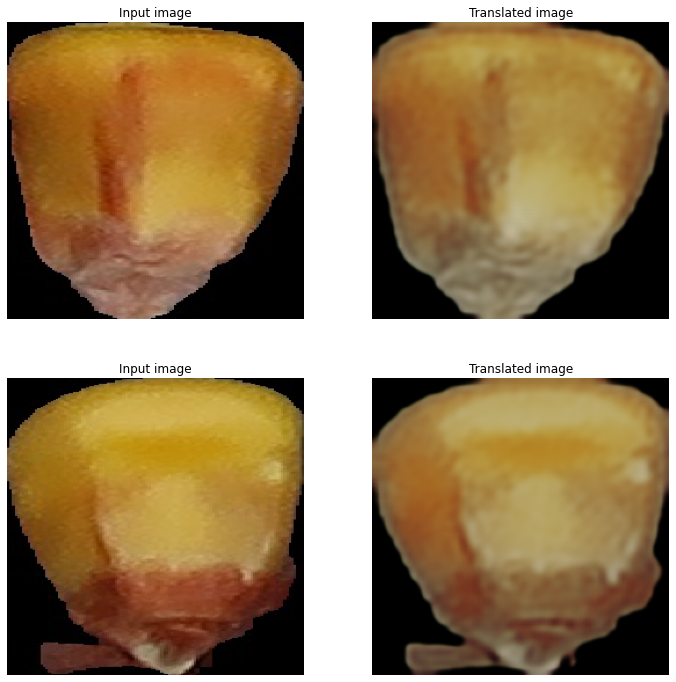

Epoch 3/10
200/200 [==============================] - 150s 751ms/step - G_loss: 1.7156 - F_loss: 1.5128 - D_X_loss: 0.2403 - D_Y_loss: 0.2395

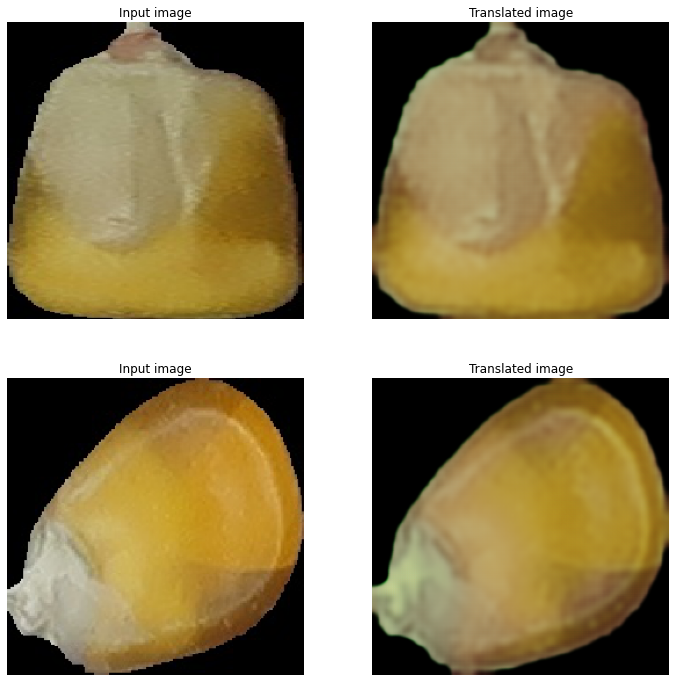

Epoch 4/10
200/200 [==============================] - 150s 751ms/step - G_loss: 1.6522 - F_loss: 1.5322 - D_X_loss: 0.2142 - D_Y_loss: 0.2486

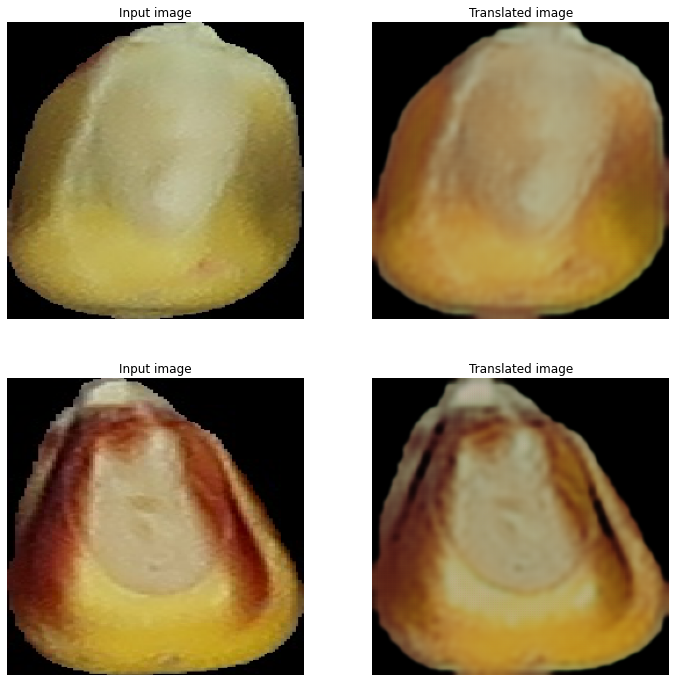

Epoch 5/10
200/200 [==============================] - 150s 751ms/step - G_loss: 1.6203 - F_loss: 1.5859 - D_X_loss: 0.1954 - D_Y_loss: 0.2394

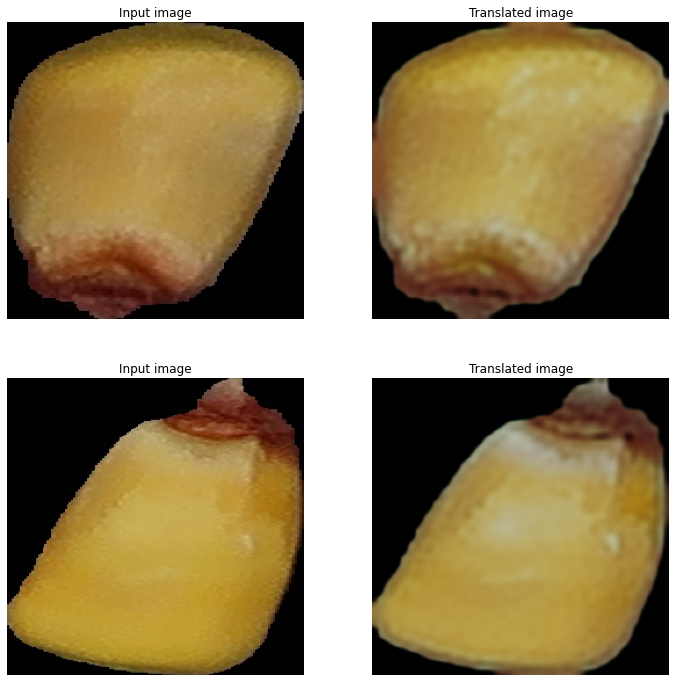

Epoch 6/10
200/200 [==============================] - 153s 763ms/step - G_loss: 1.5972 - F_loss: 1.5004 - D_X_loss: 0.2150 - D_Y_loss: 0.2445

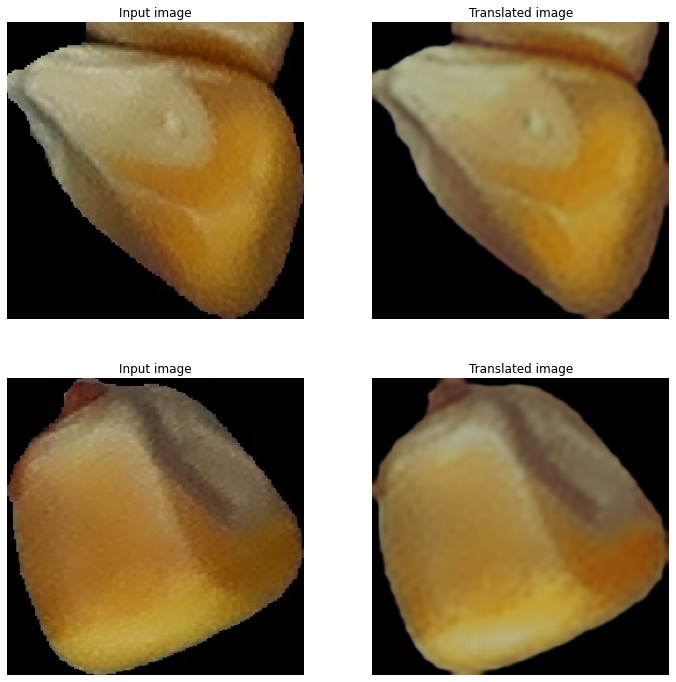

Epoch 7/10
200/200 [==============================] - 179s 897ms/step - G_loss: 1.6013 - F_loss: 1.4625 - D_X_loss: 0.2185 - D_Y_loss: 0.2387

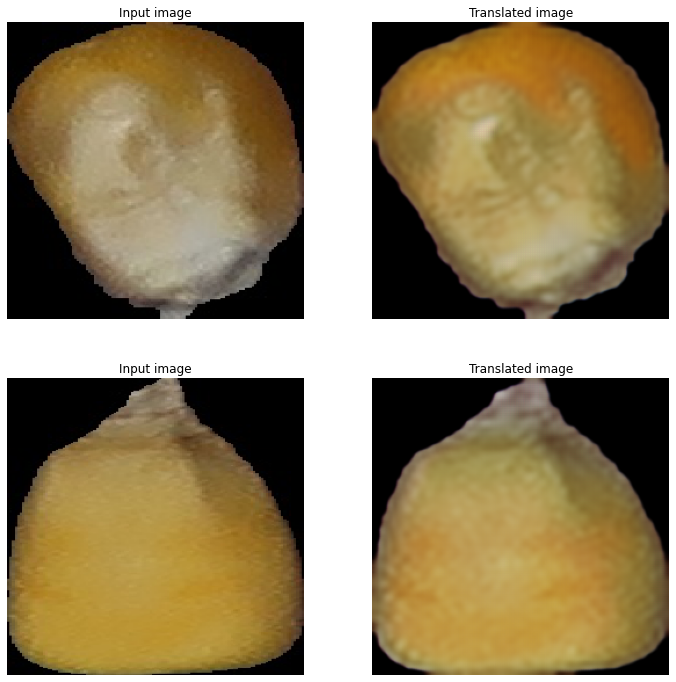

Epoch 8/10
200/200 [==============================] - 180s 901ms/step - G_loss: 1.5890 - F_loss: 1.4944 - D_X_loss: 0.2162 - D_Y_loss: 0.2395

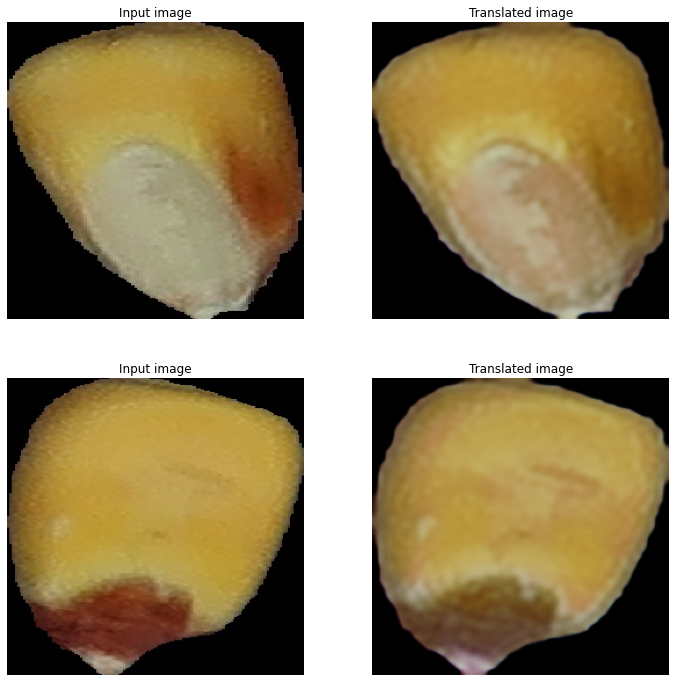

Epoch 9/10
200/200 [==============================] - 179s 897ms/step - G_loss: 1.5633 - F_loss: 1.4254 - D_X_loss: 0.2317 - D_Y_loss: 0.2369

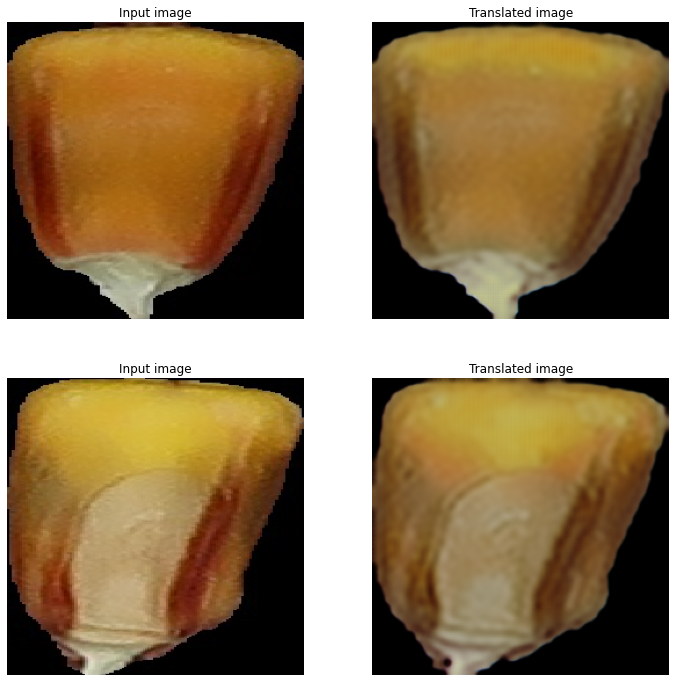

Epoch 10/10
200/200 [==============================] - 180s 898ms/step - G_loss: 1.5664 - F_loss: 1.4004 - D_X_loss: 0.2308 - D_Y_loss: 0.2343

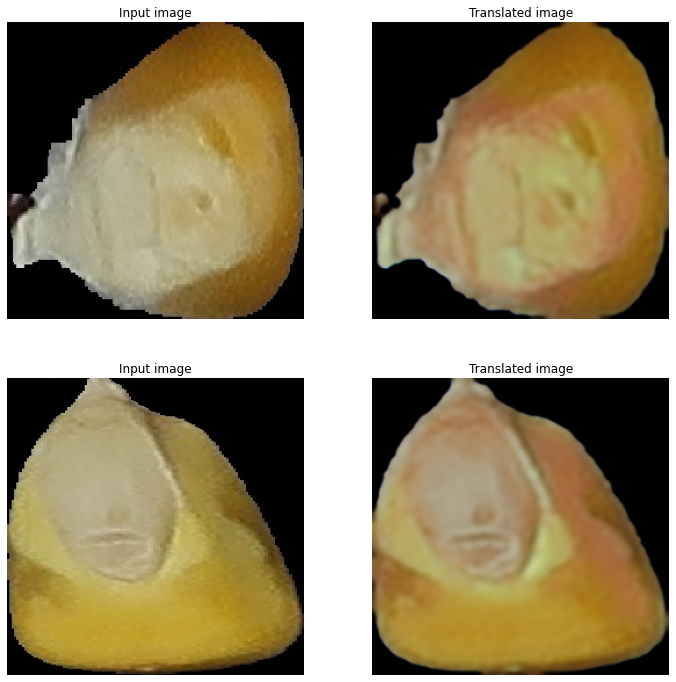

In [403]:
# Here we will train the model for just one epoch as each epoch takes around
# 7 minutes on a single P100 backed machine.
#cycle_gan_model.fit(
cycle_gan_model.fit_generator(
    #[train_H, train_C],
    cycle_gan_datagen_np(train_H, train_C),
    #tf.data.Dataset.zip((train_horses, train_zebras)),
    epochs=10,
    steps_per_epoch=train_H.n//train_H.batch_size,
    callbacks=[plotter, model_checkpoint_callback]
    #callbacks=[model_checkpoint_callback]
)

In [400]:
import os
os.getcwd()

'/shared/ds/data/compvis'

Test the performance of the model.

In [16]:

# This model was trained for 90 epochs. We will be loading those weights
# here. Once the weights are loaded, we will take a few samples from the test
# data and check the model's performance.

In [416]:
#!wget https://github.com/AakashKumarNain/CycleGAN_TF2/releases/download/v1.0/saved_checkpoints.zip
#!curl -LO https://github.com/AakashKumarNain/CycleGAN_TF2/releases/download/v1.0/saved_checkpoints.zip
#"!unzip -qq saved_checkpoints.zip
checkpoint_fp = "./model_checkpoints/cyclegan_checkpoints"

#checkpoint_filepath.replace(".\{epoch","")

In [417]:
from glob import glob
fl = glob(checkpoint_fp+"*.index")
print(fl)
weight_file = print(sorted(fl)[-1].replace(".index",""))

['./model_checkpoints/cyclegan_checkpoints.010.index', './model_checkpoints/cyclegan_checkpoints.006.index', './model_checkpoints/cyclegan_checkpoints.002.index', './model_checkpoints/cyclegan_checkpoints.001.index', './model_checkpoints/cyclegan_checkpoints.007.index', './model_checkpoints/cyclegan_checkpoints.008.index', './model_checkpoints/cyclegan_checkpoints.003.index', './model_checkpoints/cyclegan_checkpoints.005.index', './model_checkpoints/cyclegan_checkpoints.004.index', './model_checkpoints/cyclegan_checkpoints.009.index']
./model_checkpoints/cyclegan_checkpoints.010


In [440]:
# Load the checkpoints
from glob import glob
fl = glob(checkpoint_fp+"*.index")

weight_file = sorted(fl)[-1].replace(".index","")
print(weight_file)

#weight_file = "./model_checkpoints/cyclegan_checkpoints.010"

./model_checkpoints/cyclegan_checkpoints.010


In [441]:
cycle_gan_model.load_weights(weight_file).expect_partial()
print("Weights loaded successfully")

Weights loaded successfully


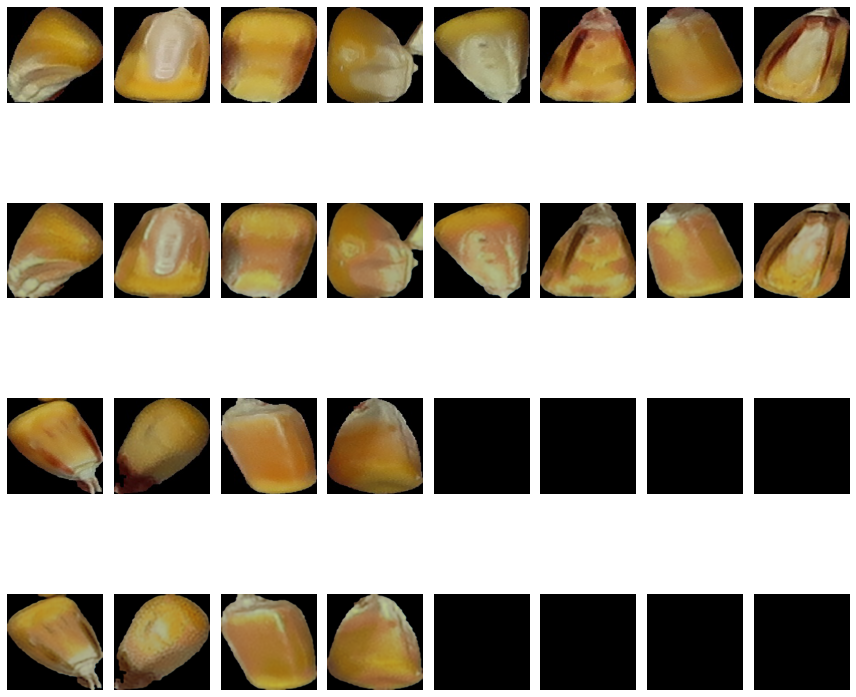

In [443]:
img_cnt = 12
col_max = 8
_, ax = plt.subplots((int(img_cnt/col_max)+1) * 2, col_max, figsize=(12, 12))
#for i, img in enumerate(test_H.take(4)):
btch = 0
ci = 0
for i in range(img_cnt):
    if i % col_max == 0 and i > 0:
        btch += 2
        ci = 0

    img = next(test_H)
    prediction = cycle_gan_model.gen_G(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).astype(np.uint8)

    ax[btch, ci].imshow(img)
    ax[btch+1, ci].imshow(prediction)
    ax[btch, ci].axis("off")
    ax[btch+1, ci].axis("off")

    ci += 1

    prediction = keras.preprocessing.image.array_to_img(prediction)
    prediction.save("predicted_img_{i}.png".format(i=i))

#print(f"ci {ci}")
for i in range(ci):
    ax[btch, ci+i].imshow(np.zeros(img.shape))
    ax[btch+1, ci+i].imshow(np.zeros(img.shape))
    ax[btch, ci+i].axis("off")
    ax[btch+1, ci+i].axis("off")

plt.tight_layout()
plt.show()

In [501]:
def display_cycle_gan_samples(G, img_x_generator, img_cnt = 12,
                              col_max = 8, figsize= None, D=None):#(12, 2)):

    text_kwargs = dict(ha='center', va='center', fontsize=6, color='C1')
    if figsize is None:
        figsize=(col_max+1,3)
    #_, ax = plt.subplots((int(img_cnt/col_max)+1) * 2, col_max, figsize=figsize)
    btch = 0
    ci = 1
    blank = None
    #_, ax = plt.subplots( 3, col_max+1, figsize=figsize)

    for i in range(img_cnt):

        img = next(img_x_generator)
        G_pred = G(img, training=False)
        prediction = G_pred[0].numpy()
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
        img = (img[0] * 127.5 + 127.5).astype(np.uint8)
        blank = np.ones(img.shape) if blank is None else blank
        discr="_"
        if D is not None:
            disc_real_x = D(tf.expand_dims(img, axis=0), training=True)
            disc_fake_x = D(G_pred, training=False)
            Dloss = discriminator_loss_fn(disc_real_x, disc_fake_x)
            discr = f"{Dloss:0.2f}"
        if i % col_max == 0:
            if i> 0:
                plt.tight_layout()
                plt.show()
            _, ax = plt.subplots( 3, col_max+1, figsize=figsize)
            ax[btch, 0].text(0.5, 0.5, 'x')
            ax[btch+1, 0].text(0.5, 0.5, 'G(x)')
            ax[btch+2, 0].text(0.5, 0.8, 'Dloss')
            ax[btch, 0].axis("off")
            ax[btch+1, 0].axis("off")
            ax[btch+2, 0].axis("off")

            ci = 1


        ax[btch, ci].imshow(img)
        ax[btch+1, ci].imshow(prediction)
        ax[btch+2, ci].text(0.3,0.8,discr)
        ax[btch, ci].axis("off")
        ax[btch+1, ci].axis("off")
        ax[btch+2, ci].axis("off")

        ci += 1

        prediction = keras.preprocessing.image.array_to_img(prediction)
        prediction.save("predicted_img_{i}.png".format(i=i))

    #print(f"ci {ci}")

    for i in range(col_max + 1 - ci):
        ax[btch, ci+i].imshow(blank)
        ax[btch+1, ci+i].imshow(blank)
        ax[btch+2, ci+i].imshow(blank)
        ax[btch, ci+i].axis("off")
        ax[btch+1, ci+i].axis("off")
        ax[btch+2, ci+i].axis("off")

    plt.tight_layout()
    plt.show()

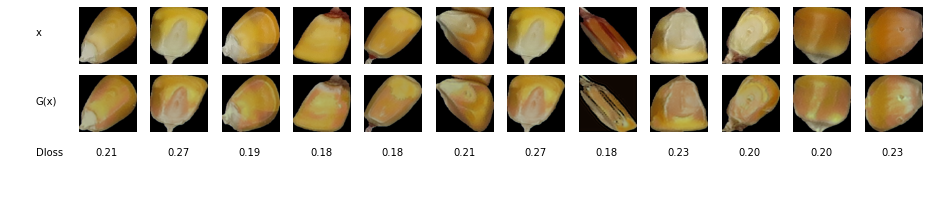

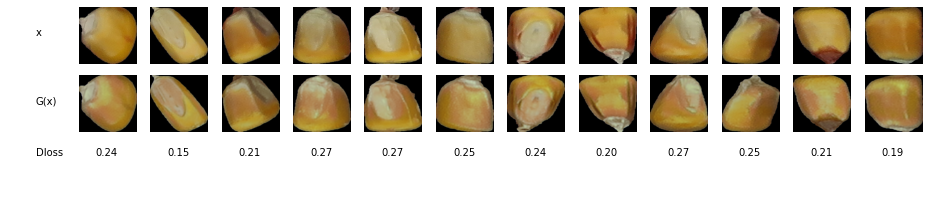

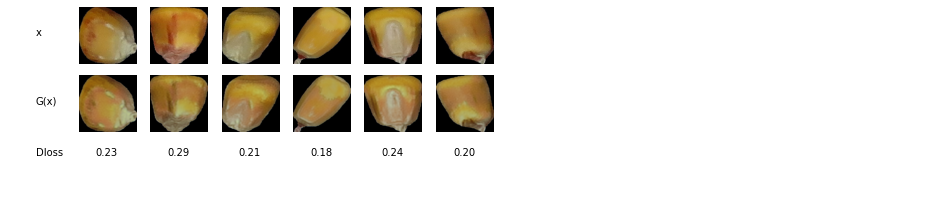

In [502]:
display_cycle_gan_samples(cycle_gan_model.gen_G, test_H, img_cnt=30, col_max=12,
                          D=cycle_gan_model.disc_X
                          )

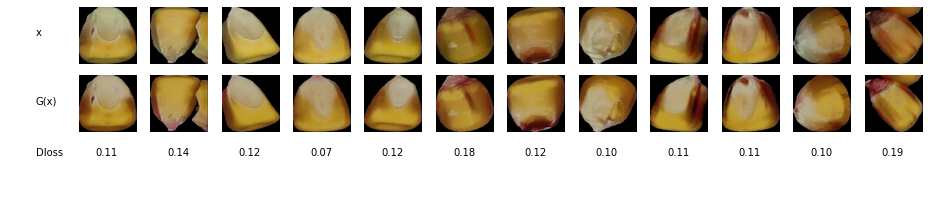

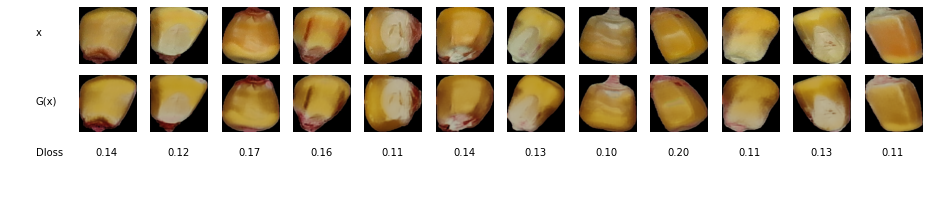

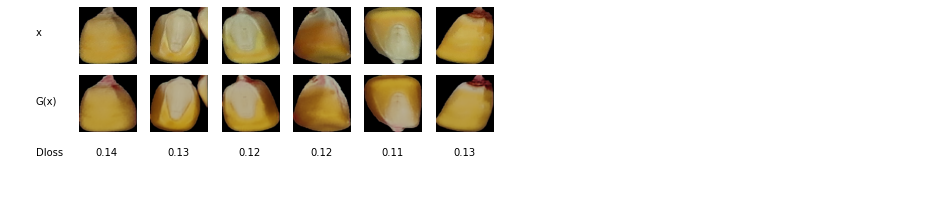

In [503]:
display_cycle_gan_samples(cycle_gan_model.gen_F, test_H, img_cnt=30, col_max=12,
                          D=cycle_gan_model.disc_Y
                          )

